# Treinamento dos modelos 

In [ ]:
#Importação das bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
!pip install shap
import shap
shap.initjs()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Bibliotecas para treinamento e cálculo de métricas 
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_roc_curve
from sklearn.linear_model import LogisticRegression 
from sklearn import preprocessing

# Algoritmo XGBoost
from xgboost import XGBClassifier

In [ ]:
#Leitura do dataset
summary_merged = pd.read_csv("https://raw.githubusercontent.com/cintiadantas20/Projeto-Tera/main/summary_merged.csv")

## Modelagem
Na etapa de modelagem vamos construir alguns modelos para executar a tarefa de classificação dos jogos das partidas entre vencedores e perdedores. 
Cada conjunto de variáveis foi submetido a três modelos de classificação: Logistic Regression, Random Forest e XGBoost. 


### Split - Treino/Teste-Básico

In [ ]:
# O conjunto básico é composto somente das variáveis do dataset original
X = summary_merged[['id_encode', 'game_encode', 'fullDate_encode', 'team_name_encode', 'week', 'duration_min', 'total_kills', 'total_assists', 'total_deaths', 
                    'total_gold', 'gold_min', 'total_damage', 'damage_min', 'red_buff', 'blue_buff', 'lord_kill', 'tortoise_kill', 'tower_destroy']]
y = summary_merged['winner']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.30, 
                                                    stratify=y,
                                                    random_state = 42)

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

### Treinamento do modelo Logistic Regression - Básico

In [ ]:
# Criando o modelo Regressão Logistica
model_reg_log = LogisticRegression()   
  
# Treinamento do modelo Regressão Logistica
model_reg_log.fit(X_train, y_train)

# Predições
y_pred = model_reg_log.predict(X_test)

###Calculando as métricas do modelo Logistic Regression - Básico

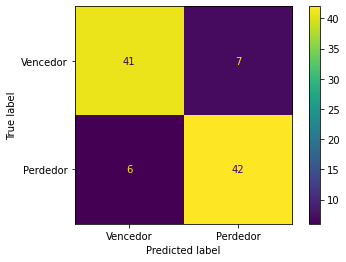

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['Vencedor', 'Perdedor'])
_ = disp.plot(values_format='d') 

In [ ]:
print("Acurácia: ", accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, pos_label=0))
print('Recall:', recall_score(y_test, y_pred, pos_label=0))
print('F1 Score:', f1_score(y_test, y_pred))

Acurácia:  0.8645833333333334
Precision: 0.8723404255319149
Recall: 0.8541666666666666
F1 Score: 0.8659793814432989


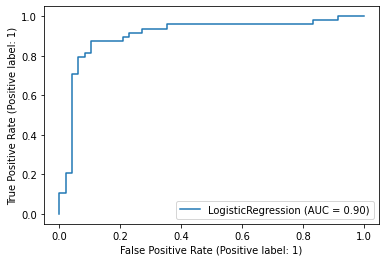

In [ ]:
plot_roc_curve(model_reg_log, X_test, y_test)

In [ ]:
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model_reg_log.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

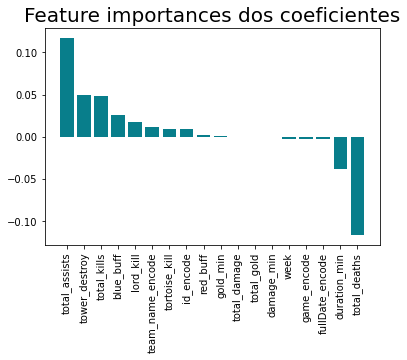

In [ ]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances dos coeficientes', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
print(importances)

           Attribute  Importance
7      total_assists    0.117048
17     tower_destroy    0.049993
6        total_kills    0.048372
14         blue_buff    0.025800
15         lord_kill    0.017215
3   team_name_encode    0.011373
16     tortoise_kill    0.009774
0          id_encode    0.009500
13          red_buff    0.002688
10          gold_min    0.000569
11      total_damage    0.000009
9         total_gold   -0.000047
12        damage_min   -0.000310
4               week   -0.002006
1        game_encode   -0.002351
2    fullDate_encode   -0.002474
5       duration_min   -0.037469
8       total_deaths   -0.116459


### Treinamento do modelo RandomForest - básico

In [ ]:
# Criando o modelo Random Forest 
model_ran_forest = RandomForestClassifier(n_estimators = 5, random_state = 42)   
  
# Treinamento do modelo Random Forest em CPU
model_ran_forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=5, random_state=42)

In [ ]:
# Predições
y_pred = model_ran_forest.predict(X_test) 

###Calculando as métricas do modelo RandomForest - básico

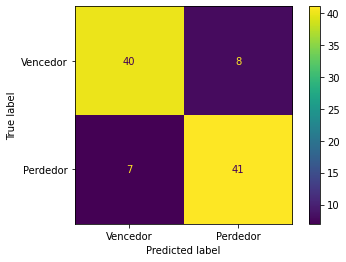

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['Vencedor', 'Perdedor'])
_ = disp.plot(values_format='d') 

In [ ]:
print("Acurácia: ", accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, pos_label=0))
print('Recall:', recall_score(y_test, y_pred, pos_label=0))
print('F1 Score:', f1_score(y_test, y_pred))

Acurácia:  0.84375
Precision: 0.851063829787234
Recall: 0.8333333333333334
F1 Score: 0.845360824742268


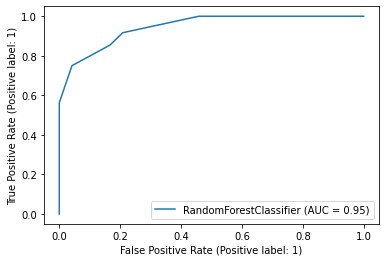

In [ ]:
plot_roc_curve(model_ran_forest, X_test, y_test)

In [ ]:
explainer = shap.TreeExplainer(model_ran_forest)
shap_values = explainer.shap_values(X_test)

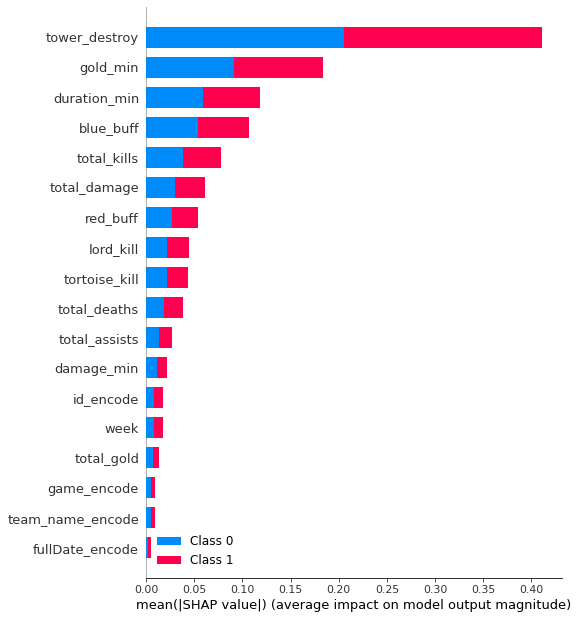

In [ ]:
shap.summary_plot(shap_values, X_train)

### Treinamento do modelo XGBoost - básico

In [ ]:
# Parametrização do XGBoost
params = {'learning_rate': 0.1,
          'colsample_bytree' : 0.3,
          'max_depth': 5,
          'objective': 'binary:logistic',
          'alpha' : 10,
          'n_estimators': 100}

# Treinamento do modelo XGBoost
model_XGboost = XGBClassifier(**params)
model_XGboost.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
                      eval_metric='auc', verbose=False)

XGBClassifier(alpha=10, colsample_bytree=0.3, max_depth=5)

In [ ]:
# Predições
y_pred = model_XGboost.predict(X_test) 

###Calculando as métricas do modelo XGBoost - básico

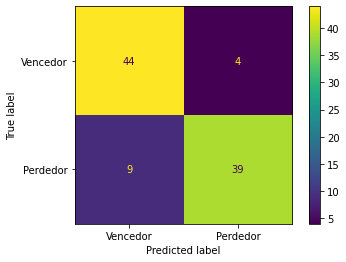

In [ ]:
cm = confusion_matrix(y_test, y_pred.astype(np.int64))
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['Vencedor', 'Perdedor'])
_ = disp.plot(values_format='d')

In [ ]:
print("Acurácia: ", accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, pos_label=0))
print('Recall:', recall_score(y_test, y_pred, pos_label=0))
print('F1 Score:', f1_score(y_test, y_pred))

Acurácia:  0.8645833333333334
Precision: 0.8301886792452831
Recall: 0.9166666666666666
F1 Score: 0.8571428571428572


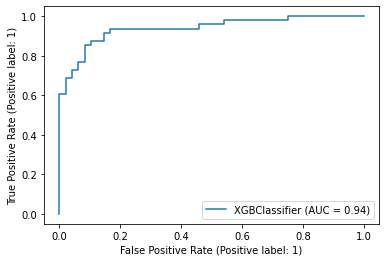

In [ ]:
plot_roc_curve(model_XGboost, X_test, y_test)

In [ ]:
explainer = shap.TreeExplainer(model_ran_forest)
shap_values = explainer.shap_values(X_test)

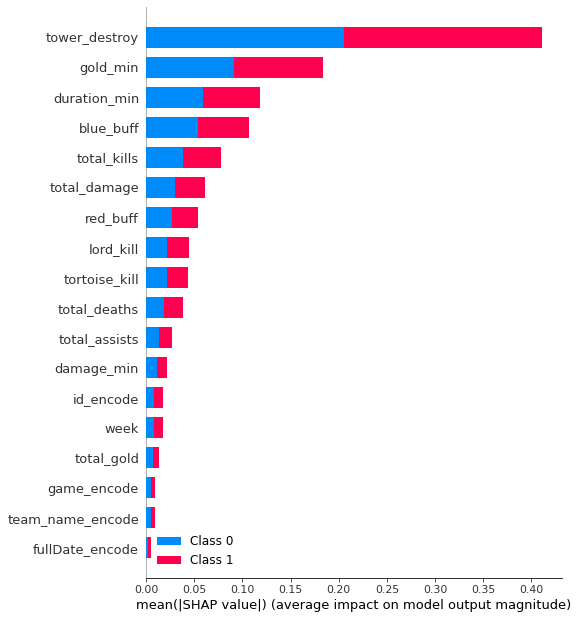

In [ ]:
shap.summary_plot(shap_values, X_train)

### COMPARANDO MODELOS BÁSICOS

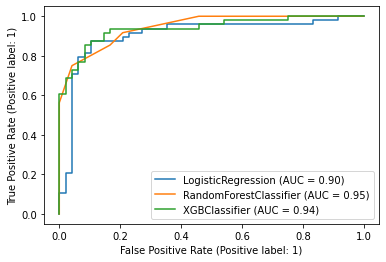

In [ ]:
# Comparando as curvas roc dos 3 modelos
classifiers = [model_reg_log, model_ran_forest, model_XGboost]
ax = plt.gca()
for i in classifiers:
    plot_roc_curve(i, X_test, y_test, ax=ax)

In [ ]:
# Comparação das métricas dos 3 modelos 
for i in classifiers:
    y_pred = i.predict(X_test)
    print(f'**{type(i).__name__}**')
    print(f'Acurácia: {round(accuracy_score(y_test, y_pred), 2)}\nPrecisão: {round(precision_score(y_test, y_pred), 2)}\nRecall: {round(recall_score(y_test, y_pred), 2)}\nRF1 Score: {round(f1_score(y_test, y_pred), 2)}')
    print('__________________')

**LogisticRegression**
Acurácia: 0.86
Precisão: 0.86
Recall: 0.88
RF1 Score: 0.87
__________________
**RandomForestClassifier**
Acurácia: 0.84
Precisão: 0.84
Recall: 0.85
RF1 Score: 0.85
__________________
**XGBClassifier**
Acurácia: 0.86
Precisão: 0.91
Recall: 0.81
RF1 Score: 0.86
__________________


### Split - Treino/teste-novas variáveis

In [ ]:
# O conjunto com novas variáveis foi obtido após a feature engineering, com exclusão das variáveis que deram origem às novas 
#(total_kills, total_assists, total_deaths, total_gold, total_damage, red_buff, blue_buff, lord_kill, tortoise_kill, tower_destroy)
X = summary_merged[['id_encode', 'game_encode', 'fullDate_encode', 'team_name_encode', 'week', 'duration_min', 'gold_min', 'damage_min', 'sum_buffs', 'KDA', 'assists_taken', 
                                  'gold_w3', 'gold_w1', 'damage_w3', 'damage_w1']]
y = summary_merged['winner']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.30, 
                                                    stratify=y,
                                                    random_state = 42)

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

### Treinamento do modelo Logistic Regression - novas variáveis

In [ ]:
# Criando o modelo Regressão Logistica
model_reg_log = LogisticRegression()   
  
# Treinamento do modelo Regressão Logistica
model_reg_log.fit(X_train, y_train) 

LogisticRegression()

In [ ]:
# Predições
y_pred = model_reg_log.predict(X_test)

###Calculando as métricas do modelo Logistic Regression - novas variáveis

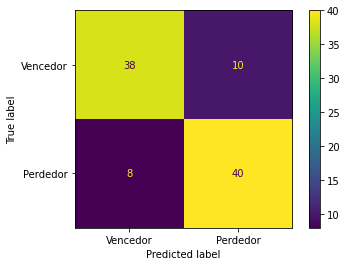

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['Vencedor', 'Perdedor'])
_ = disp.plot(values_format='d') 

In [ ]:
print("Acurácia: ", accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, pos_label=0))
print('Recall:', recall_score(y_test, y_pred, pos_label=0))
print('F1 Score:', f1_score(y_test, y_pred))

Acurácia:  0.8125
Precision: 0.8260869565217391
Recall: 0.7916666666666666
F1 Score: 0.816326530612245


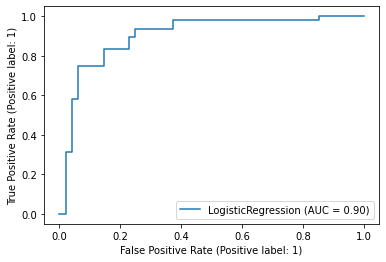

In [ ]:
plot_roc_curve(model_reg_log, X_test, y_test)

In [ ]:
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model_reg_log.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

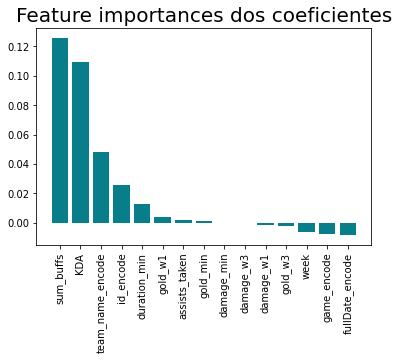

In [ ]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances dos coeficientes', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
print(importances)

           Attribute  Importance
8          sum_buffs    0.125950
9                KDA    0.109126
3   team_name_encode    0.047826
0          id_encode    0.025768
5       duration_min    0.012551
12           gold_w1    0.003935
10     assists_taken    0.001512
6           gold_min    0.000930
7         damage_min    0.000003
13         damage_w3   -0.000130
14         damage_w1   -0.001335
11           gold_w3   -0.002120
4               week   -0.006634
1        game_encode   -0.007548
2    fullDate_encode   -0.008645


### Treinamento do modelo RandomForest - novas variáveis

In [ ]:
# Criando o modelo Random Forest 
model_ran_forest = RandomForestClassifier(n_estimators = 5, random_state = 42)   
  
# Treinamento do modelo Random Forest em CPU
model_ran_forest.fit(X_train, y_train) 

RandomForestClassifier(n_estimators=5, random_state=42)

In [ ]:
# Predições
y_pred = model_ran_forest.predict(X_test) 

###Calculando as métricas do modelo RandomForest - novas variáveis

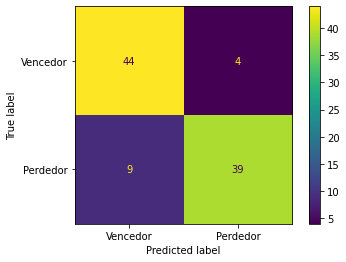

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['Vencedor', 'Perdedor'])
_ = disp.plot(values_format='d') 

In [ ]:
print("Acurácia: ", accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, pos_label=0))
print('Recall:', recall_score(y_test, y_pred, pos_label=0))
print('F1 Score:', f1_score(y_test, y_pred))

Acurácia:  0.8645833333333334
Precision: 0.8301886792452831
Recall: 0.9166666666666666
F1 Score: 0.8571428571428572


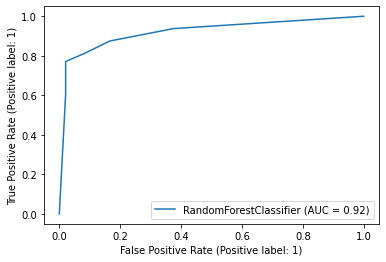

In [ ]:
plot_roc_curve(model_ran_forest, X_test, y_test)

In [ ]:
explainer = shap.TreeExplainer(model_ran_forest)
shap_values = explainer.shap_values(X_test)

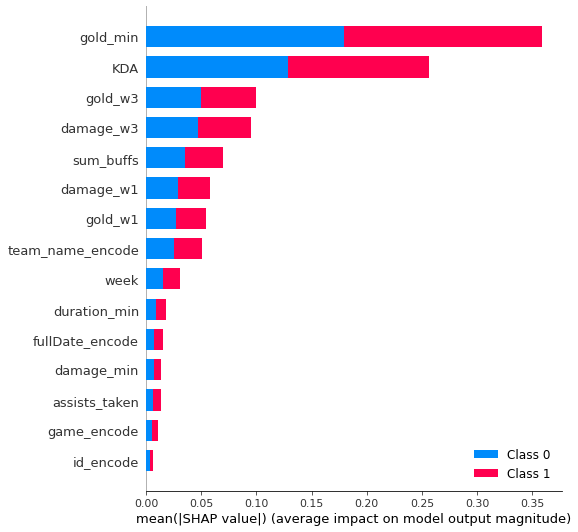

In [ ]:
shap.summary_plot(shap_values, X_train)

###Treinamento do modelo XGBoost - novas variáveis 

In [ ]:
# Parametrização do XGBoost
params = {'learning_rate': 0.1,
          'colsample_bytree' : 0.3,
          'max_depth': 5,
          'objective': 'binary:logistic',
          'alpha' : 10,
          'n_estimators': 100}

# Treinamento do modelo XGBoost
model_XGboost = XGBClassifier(**params)
model_XGboost.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
                      eval_metric='auc', verbose=False)

XGBClassifier(alpha=10, colsample_bytree=0.3, max_depth=5)

In [ ]:
# Predições
y_pred = model_XGboost.predict(X_test)

###Calculando as métricas do modelo XGBoost - novas variáveis 

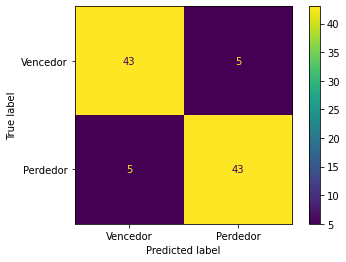

In [ ]:
cm = confusion_matrix(y_test, y_pred.astype(np.int64))
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['Vencedor', 'Perdedor'])
_ = disp.plot(values_format='d') 

In [ ]:
print("Acurácia: ", accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, pos_label=0))
print('Recall:', recall_score(y_test, y_pred, pos_label=0))
print('F1 Score:', f1_score(y_test, y_pred))

Acurácia:  0.8958333333333334
Precision: 0.8958333333333334
Recall: 0.8958333333333334
F1 Score: 0.8958333333333334


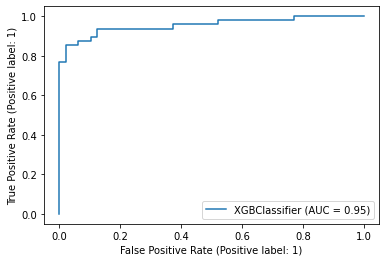

In [ ]:
plot_roc_curve(model_XGboost, X_test, y_test)

In [ ]:
explainer = shap.TreeExplainer(model_ran_forest)
shap_values = explainer.shap_values(X_test)

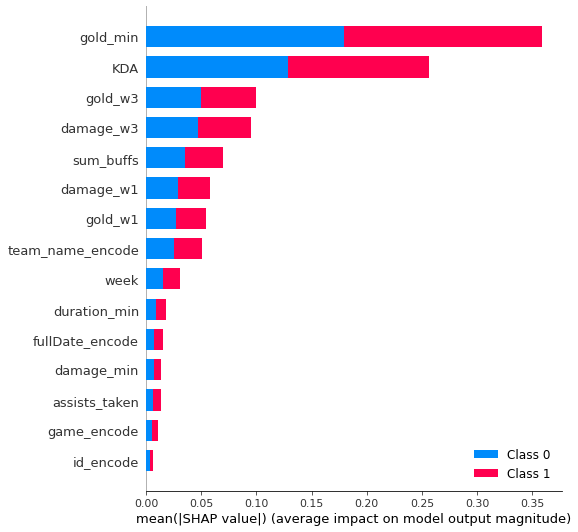

In [ ]:
shap.summary_plot(shap_values, X_train)

### COMPARANDO MODELOS NOVAS VARIÁVEIS

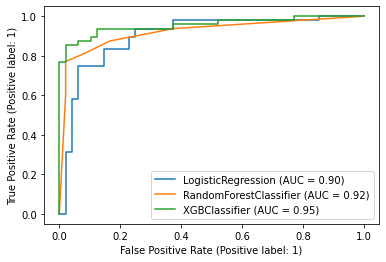

In [ ]:
# comparando as curvas roc dos 3 modelos
classifiers = [model_reg_log, model_ran_forest, model_XGboost]
ax = plt.gca()
for i in classifiers:
    plot_roc_curve(i, X_test, y_test, ax=ax)

In [ ]:
# comparando as métricas dos 3 modelos
for i in classifiers:
    y_pred = i.predict(X_test)
    print(f'**{type(i).__name__}**')
    print(f'Acurácia: {round(accuracy_score(y_test, y_pred), 2)}\nPrecisão: {round(precision_score(y_test, y_pred), 2)}\nRecall: {round(recall_score(y_test, y_pred), 2)}\nRF1 Score: {round(f1_score(y_test, y_pred), 2)}')
    print('__________________')

**LogisticRegression**
Acurácia: 0.81
Precisão: 0.8
Recall: 0.83
RF1 Score: 0.82
__________________
**RandomForestClassifier**
Acurácia: 0.86
Precisão: 0.91
Recall: 0.81
RF1 Score: 0.86
__________________
**XGBClassifier**
Acurácia: 0.9
Precisão: 0.9
Recall: 0.9
RF1 Score: 0.9
__________________


###Split - Treino/Teste-Completo 

In [ ]:
# conjunto completo (variáveis novas e as do dataset original)
X = summary_merged[['id_encode', 'game_encode', 'fullDate_encode', 'team_name_encode', 'week', 'duration_min', 'total_kills', 'total_assists', 'total_deaths', 
                    'total_gold', 'gold_min', 'total_damage', 'damage_min', 'red_buff', 'blue_buff', 'lord_kill', 'tortoise_kill', 
                    'tower_destroy', 'sum_buffs', 'KDA', 'assists_taken', 'gold_w3', 'gold_w1', 'damage_w3', 'damage_w1']]
y = summary_merged['winner']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.30, 
                                                    stratify=y,
                                                    random_state = 42)

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

### Treinamento do modelo Logistic Regression - Completo

In [ ]:
# Criando o modelo Regressão Logistica
model_reg_log = LogisticRegression()   
  
# Treinamento do modelo Regressão Logistica
model_reg_log.fit(X_train, y_train) 

LogisticRegression()

In [ ]:
# Predições
y_pred = model_reg_log.predict(X_test)

###Calculando as métricas do modelo - Logistic Regression - Completo

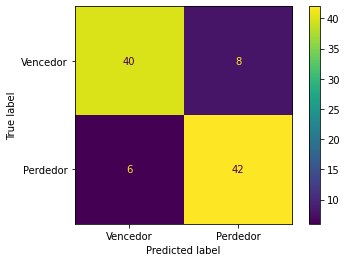

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['Vencedor', 'Perdedor'])
_ = disp.plot(values_format='d') 

In [ ]:
print("Acurácia: ", accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, pos_label=0))
print('Recall:', recall_score(y_test, y_pred, pos_label=0))
print('F1 Score:', f1_score(y_test, y_pred))

Acurácia:  0.8541666666666666
Precision: 0.8695652173913043
Recall: 0.8333333333333334
F1 Score: 0.8571428571428572


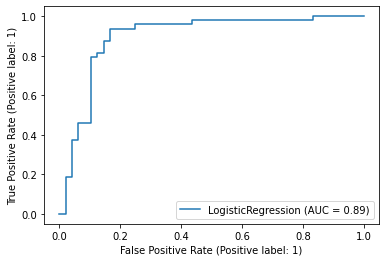

In [ ]:
plot_roc_curve(model_reg_log, X_test, y_test)

In [ ]:
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model_reg_log.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

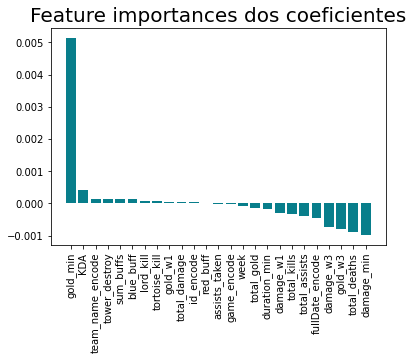

In [ ]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances dos coeficientes', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
print(importances)

           Attribute    Importance
10          gold_min  5.147230e-03
19               KDA  4.030615e-04
3   team_name_encode  1.472693e-04
17     tower_destroy  1.311782e-04
18         sum_buffs  1.231800e-04
14         blue_buff  1.229019e-04
15         lord_kill  8.091217e-05
16     tortoise_kill  7.892377e-05
22           gold_w1  6.028826e-05
11      total_damage  5.730551e-05
0          id_encode  5.273130e-05
13          red_buff  2.780579e-07
20     assists_taken -1.316658e-05
1        game_encode -1.676033e-05
4               week -7.939059e-05
9         total_gold -1.427767e-04
5       duration_min -1.793375e-04
24         damage_w1 -2.981066e-04
6        total_kills -3.424858e-04
7      total_assists -3.905303e-04
2    fullDate_encode -4.529783e-04
23         damage_w3 -7.234368e-04
21           gold_w3 -7.802247e-04
8       total_deaths -8.938975e-04
12        damage_min -9.931061e-04


### Treinamento do modelo RandomForest - Completo 

In [ ]:
# Criando o modelo Random Forest 
model_ran_forest = RandomForestClassifier(n_estimators = 5, random_state = 42)   
  
# Treinamento do modelo Random Forest em CPU
model_ran_forest.fit(X_train, y_train) 

RandomForestClassifier(n_estimators=5, random_state=42)

In [ ]:
# Predições
y_pred = model_ran_forest.predict(X_test) 

###Calculando as métricas do modelo - RandomForest - Completo

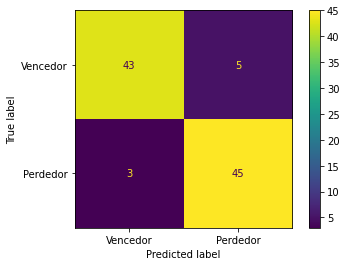

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['Vencedor', 'Perdedor'])
_ = disp.plot(values_format='d') 

In [ ]:
print("Acurácia: ", accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, pos_label=0))
print('Recall:', recall_score(y_test, y_pred, pos_label=0))
print('F1 Score:', f1_score(y_test, y_pred))

Acurácia:  0.9166666666666666
Precision: 0.9347826086956522
Recall: 0.8958333333333334
F1 Score: 0.9183673469387755


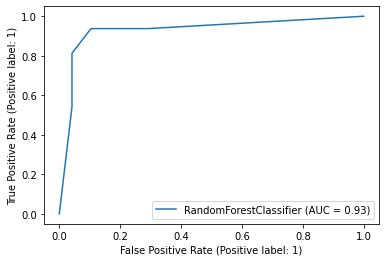

In [ ]:
plot_roc_curve(model_ran_forest, X_test, y_test)

In [ ]:
explainer = shap.TreeExplainer(model_ran_forest)
shap_values = explainer.shap_values(X_test)

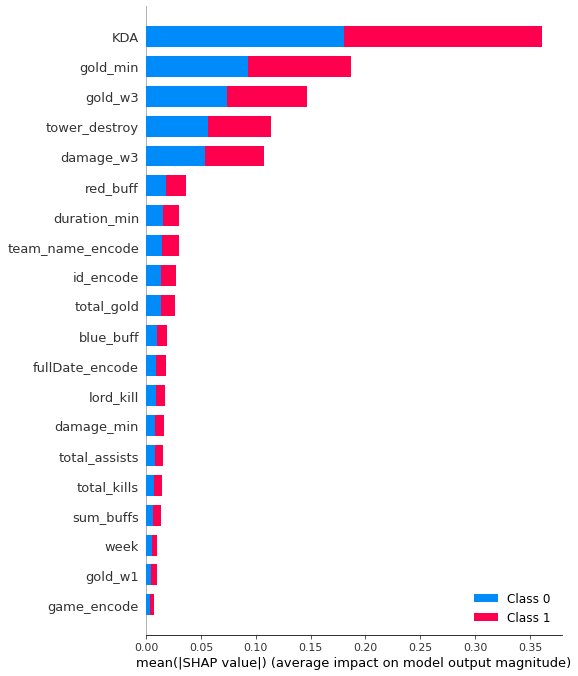

In [ ]:
shap.summary_plot(shap_values, X_train)

###Treinamento do modelo XGBoost - Completo

In [ ]:
# Parametrização do XGBoost
params = {'learning_rate': 0.1,
          'colsample_bytree' : 0.3,
          'max_depth': 5,
          'objective': 'binary:logistic',
          'alpha' : 10,
          'n_estimators': 100}

# Treinamento do modelo XGBoost
model_XGboost = XGBClassifier(**params)
model_XGboost.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
                      eval_metric='auc', verbose=False)

XGBClassifier(alpha=10, colsample_bytree=0.3, max_depth=5)

In [ ]:
# Predições
y_pred = model_XGboost.predict(X_test)

###Calculando as métricas do modelo - XGBoost - Completo

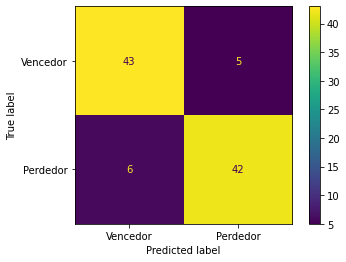

In [ ]:
cm = confusion_matrix(y_test, y_pred.astype(np.int64))
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['Vencedor', 'Perdedor'])
_ = disp.plot(values_format='d') 

In [ ]:
print("Acurácia: ", accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, pos_label=0))
print('Recall:', recall_score(y_test, y_pred, pos_label=0))
print('F1 Score:', f1_score(y_test, y_pred))

Acurácia:  0.8854166666666666
Precision: 0.8775510204081632
Recall: 0.8958333333333334
F1 Score: 0.8842105263157894


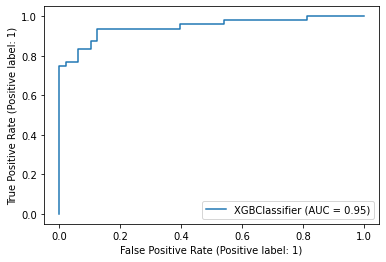

In [ ]:
plot_roc_curve(model_XGboost, X_test, y_test)

In [ ]:
explainer = shap.TreeExplainer(model_ran_forest)
shap_values = explainer.shap_values(X_test)

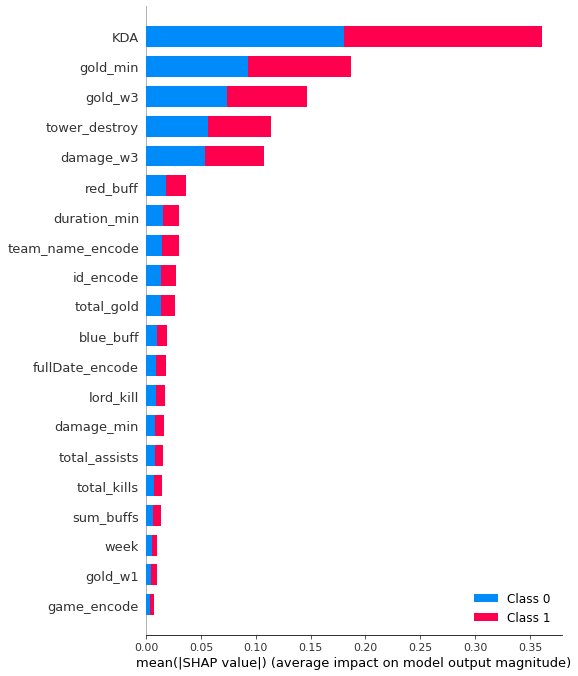

In [ ]:
shap.summary_plot(shap_values, X_train)

### COMPARANDO MODELOS COMPLETOS

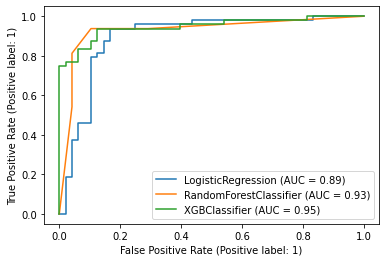

In [ ]:
# comparando as curvas roc dos 3 modelos
classifiers = [model_reg_log, model_ran_forest, model_XGboost]
ax = plt.gca()
for i in classifiers:
    plot_roc_curve(i, X_test, y_test, ax=ax)

In [ ]:
# comparando as métricas dos 3 modelos
for i in classifiers:
    y_pred = i.predict(X_test)
    print(f'**{type(i).__name__}**')
    print(f'Acurácia: {round(accuracy_score(y_test, y_pred), 2)}\nPrecisão: {round(precision_score(y_test, y_pred), 2)}\nRecall: {round(recall_score(y_test, y_pred), 2)}\nRF1 Score: {round(f1_score(y_test, y_pred), 2)}')
    print('__________________')

**LogisticRegression**
Acurácia: 0.85
Precisão: 0.84
Recall: 0.88
RF1 Score: 0.86
__________________
**RandomForestClassifier**
Acurácia: 0.92
Precisão: 0.9
Recall: 0.94
RF1 Score: 0.92
__________________
**XGBClassifier**
Acurácia: 0.89
Precisão: 0.89
Recall: 0.88
RF1 Score: 0.88
__________________


### Comentários sobre os modelos 

Para cada um dos modelos, após o split de treino  e teste em uma proporção 70/30, foram utilizadas algumas métricas de avaliação, quais sejam:. Matriz de confusão, Precision, Recall, F1 Score e Curva ROC/AUC. 
- pode-se dizer que os modelos performaram muito bem, tendo em vista que a menor métrica foi a precisão para a regressão logística do conjunto com novas variáveis, no valor de 0,80. 
- Em relação à matriz de confusão, verifica-se que os erros totais dos modelos variam de 8 a 18, sendo o modelo Random Forest para o conjunto completo de dados o que teve o melhor desempenho e a regressão logística para o conjunto de novas variáveis, o pior.
- Essa métrica sozinha não é suficiente para a escolha do modelo, pois para o problema de negócio, os erros de classificação de vencedores ou perdedores possuem a mesma gravidade.
- os erros de classificação possuem o mesmo peso, de modo que as métricas de acurácia, precisão e recall são igualmente avaliadas. Dessa forma, a decisão se baseou no F1 Score, cujo cálculo se baseia na precisão e no recall, e na área abaixo da curva ROC (AUC), que aponta a porcentagem de acertos de forma geral.
- Outra técnica que embasou a decisão foi a feature importance, que lista as variáveis que mais explicam a variável de interesse para cada modelo.
- Conforme a lógica do jogo, a vitória de um time poderia ser explicada por variáveis relacionadas ao ganho de ouro, dano, mortes provocadas e assistências obtidas.
- Foi escolhido como melhor modelo para o problema de negócio definido o XGBoost Classifier para o conjunto de novas variáveis, inclusive pela quantidade reduzida de features, o que diminuiria o custo de processamento do modelo, e pela correlação existente entre as variáveis originais e as criadas, que foram derivadas das primeiras.
- De fato, notamos que, para este modelo, as duas primeiras variáveis (gold_min e KDA) explicam grande parte do modelo, tornando-o ainda menos custoso.


